In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier
import pandas as pd

**1. Загрузка и подготовка данных**

In [5]:
data = fetch_openml('credit-g', version=1, as_frame=True)
df = data.frame.copy()
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


# Кодируем целевой признак

In [6]:
df['class'] = LabelEncoder().fit_transform(df['class'])  # good=1, bad=0
y = df['class']
X = df.drop(columns=['class'])

In [7]:
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,0
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,1
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,1
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,1
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,0


# Категориальные признаки

In [8]:
# 1. Убедимся, что типы — category
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 2. Получим индексы категориальных признаков
cat_features = [X.columns.get_loc(col) for col in X.select_dtypes(include='category').columns]
cat_features


[0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

#  Разделение на Train/Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

2. GridSearchCV со стратифицированной кросс-валидацией

In [10]:
# 2. Модель
model = CatBoostClassifier(
    cat_features=cat_features,
    verbose=0,
    random_seed=42,
    eval_metric='AUC'
)

# 3. Сетка параметров
param_grid = {
    'iterations': [200, 500],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.1]
}

# 4. Стратифицированная 5-fold кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. GridSearch
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# 6. Обучение (передаём cat_features явно)
grid_search.fit(X_train, y_train, cat_features=cat_features)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7bba7c372b50>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'iterations': [200, 500],
                         'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

def manual_cv_scores(model, X, y, cat_features, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    aucs, f1s, precisions, recalls = [], [], [], []

    for train_idx, valid_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_tr, y_tr, cat_features=cat_features)

        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_proba))
        f1s.append(f1_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

    print("Кросс-валидация (train set):")
    print(f"AUC-ROC   : {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"F1-score  : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Precision : {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall    : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")


In [14]:
# Лучшая модель
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'depth': 4, 'iterations': 500, 'learning_rate': 0.03}


In [18]:
import pickle

**Сохрание модели**

In [19]:
model_filename = 'German Credit_gradient_boosting_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

**Расчет статистик для обучающей выборки**

In [24]:
manual_cv_scores(best_model, X_train, y_train, cat_features)

Кросс-валидация (train set):
AUC-ROC   : 0.7886 ± 0.0328
F1-score  : 0.8315 ± 0.0154
Precision : 0.7876 ± 0.0214
Recall    : 0.8816 ± 0.0278


Расчет статистик для тестовой  выборки

In [25]:
# Предсказания
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Метрики на тестовой выборке:")
print(f"AUC-ROC:   {auc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


Метрики на тестовой выборке:
AUC-ROC:   0.7826
F1-score:  0.8383
Precision: 0.8035
Recall:    0.8762


Визуализация важности признаков (feature importance)

<ipython-input-26-db1926bebe2e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


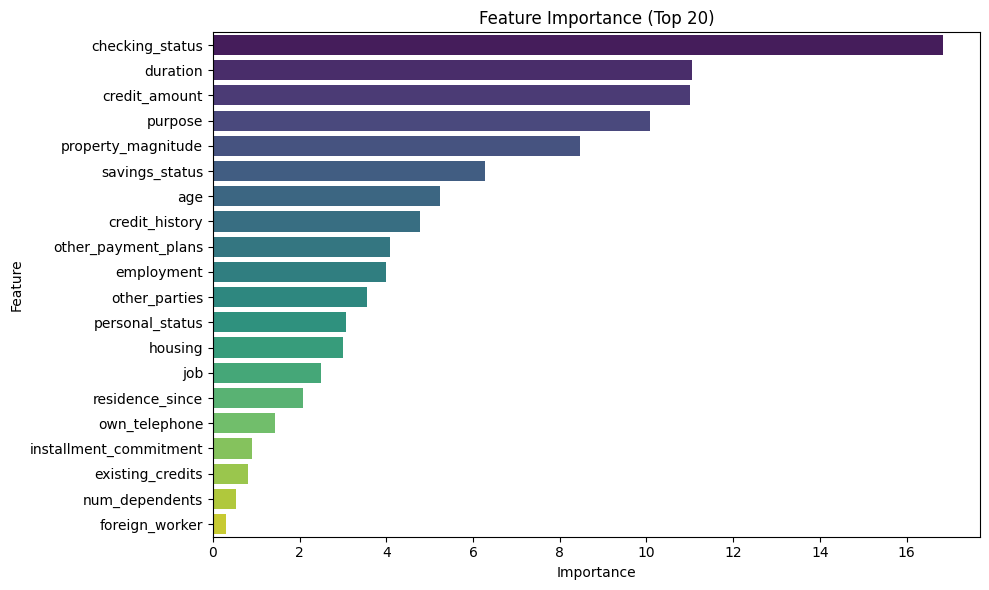

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.get_feature_importance()
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title('Feature Importance (Top {})'.format(top_n))
    plt.tight_layout()
    plt.show()

# Вызов:
plot_feature_importance(best_model, X.columns)


ROC-кривая на обучающей выборке (по фолдам) и тестовой выборке

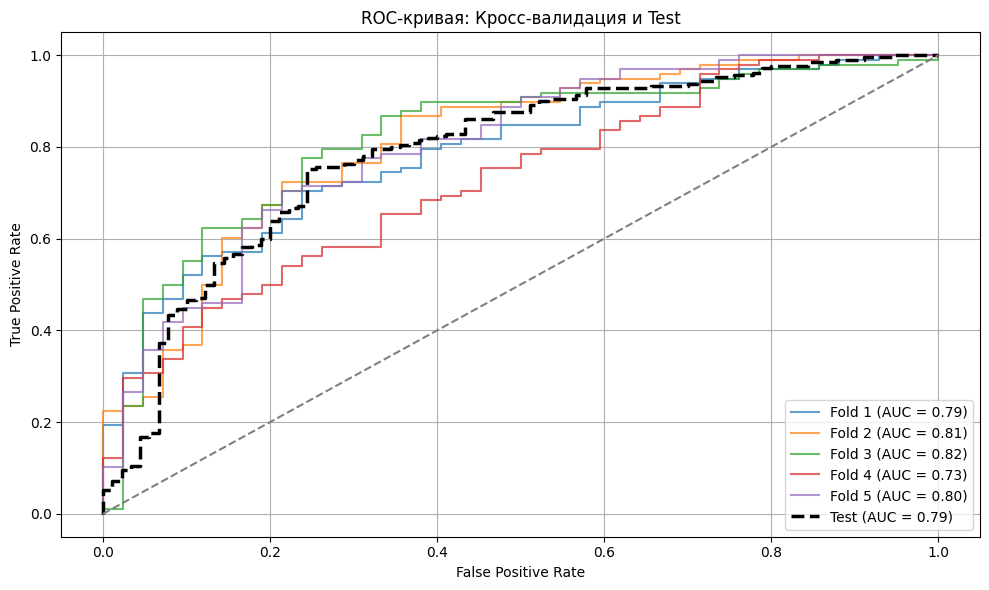

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_cv_and_test_roc(model, X_train, y_train, X_test, y_test, cat_features, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    plt.figure(figsize=(10, 6))

    # Кросс-валидация
    for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr, cat_features=cat_features)
        y_val_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label=f'Fold {i+1} (AUC = {roc_auc:.2f})', alpha=0.7)

    # ROC на тестовой выборке
    model.fit(X_train, y_train, cat_features=cat_features)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    test_auc = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='black', linestyle='--',
             label=f'Test (AUC = {test_auc:.2f})', linewidth=2.5)

    # График
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая: Кросс-валидация и Test')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Вызов:
plot_cv_and_test_roc(best_model, X_train, y_train, X_test, y_test, cat_features)
